In [54]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project path to os.path
current_path = os.path.abspath('.')
project_name = 'California_Wild_Fire_Prediction'
project_path = os.path.join(current_path.split(project_name)[0], project_name)
print(project_path)
sys.path.append(project_path)

/Users/shawn/Documents/sjsu/2025-1/ML_CMPE257/California_Wild_Fire_Prediction


# Data Processing

In [55]:
# Get total data we made together
df = pd.read_csv(os.path.join(project_path, 'data', 'final_data', 'total_data.csv'))
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['date', 'latitude', 'longitude'], keep='first', inplace=True)

In [56]:
# Just minor processing dataframe
# Drop the FBFM_VALUE column if it's all missing or a constant (to avoid unusable feature)
if 'FBFM_VALUE' in df.columns and df['FBFM_VALUE'].nunique() <= 1:
    df.drop(columns=['FBFM_VALUE'], inplace=True)

# Fix latitude/longitude duplication issues: use 'lat'/'lng' as the correct coordinates
if 'lat' in df.columns and 'latitude' in df.columns:
    df.drop(columns=['latitude', 'longitude'], inplace=True)
    df.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)

Date is in string format, so we should fix to datetime format and extract date, month, etc.

This is important because we are dealing with 'time' data

In [57]:
def process_and_fill_date_column(df, date_col='date'):
    """
    Process a mixed-format date column, extract date features,
    and fill missing values in those features.
    """
    df = df.copy()
    df[date_col] = [x[:10] for x in df[date_col]]
    df[date_col] = pd.to_datetime(df[date_col])

    # Extract features
    df[f'{date_col}_year'] = df[date_col].dt.year.astype(int)
    df[f'{date_col}_month'] = df[date_col].dt.month.astype(int)
    df[f'{date_col}_day'] = df[date_col].dt.day.astype(int)
    df[f'{date_col}_weekday'] = df[date_col].dt.weekday.astype(int)

    # Fill missing values with mode or a safe fallback
    for col in [f'{date_col}_year', f'{date_col}_month', f'{date_col}_day', f'{date_col}_weekday']:
        if df[col].isna().any():
            mode_val = df[col].mode(dropna=True)
            fallback = mode_val[0] if not mode_val.empty else 0
            df[col] = df[col].fillna(fallback)

    return df

# Drop rows with any missing values (small percentage of data)
df.dropna(inplace=True)
df = process_and_fill_date_column(df)

Below is the process of a **very simple feature engineering**. I'm just adding `mean`, `variable` of climate data.

For more feature engineering, you can try using `quantile`, `differentiate`, `min`, `max`, etc.

In [58]:
# Compute 14-day mean and variance for climate features
climate_vars = ['DayAirTmpAvg', 'DayPrecip', 'DayRelHumAvg', 'DaySoilTmpAvg', 'DayWindSpdAvg']
for var in climate_vars:
    cols = [c for c in df.columns if c.startswith(var)]
    df[f'{var}_mean14'] = df[cols].mean(axis=1)
    df[f'{var}_var14']  = df[cols].var(axis=1)
    # df.drop(columns=cols, inplace=True)

Also, we have to delete columns that have very close meaning to `is_fire` column, which the model will just predict fire using those critical columns.

In [59]:
# Remove outcome leakage feature
df.drop(columns=['acres_burned'], inplace=True, errors='ignore')
df.drop(columns=['burn_probability'], inplace=True, errors='ignore')
df.drop(columns=['conditional_flame_length'], inplace=True, errors='ignore')
df.drop(columns=['flame_length_exceedance_4ft'], inplace=True, errors='ignore')
df.drop(columns=['flame_length_exceedance_8ft'], inplace=True, errors='ignore')
df.drop(columns=['distance_km'], inplace=True, errors='ignore')
df.drop(columns=['wildfire_hazard_potential'], inplace=True, errors='ignore')
df.drop(columns=['latitude', 'longitude'], inplace=True)

In [60]:
df.columns

Index(['DayAirTmpAvg01', 'DayAirTmpAvg02', 'DayAirTmpAvg03', 'DayAirTmpAvg04',
       'DayAirTmpAvg05', 'DayAirTmpAvg06', 'DayAirTmpAvg07', 'DayAirTmpAvg08',
       'DayAirTmpAvg09', 'DayAirTmpAvg10', 'DayAirTmpAvg11', 'DayAirTmpAvg12',
       'DayAirTmpAvg13', 'DayAirTmpAvg14', 'DayPrecip01', 'DayPrecip02',
       'DayPrecip03', 'DayPrecip04', 'DayPrecip05', 'DayPrecip06',
       'DayPrecip07', 'DayPrecip08', 'DayPrecip09', 'DayPrecip10',
       'DayPrecip11', 'DayPrecip12', 'DayPrecip13', 'DayPrecip14',
       'DayRelHumAvg01', 'DayRelHumAvg02', 'DayRelHumAvg03', 'DayRelHumAvg04',
       'DayRelHumAvg05', 'DayRelHumAvg06', 'DayRelHumAvg07', 'DayRelHumAvg08',
       'DayRelHumAvg09', 'DayRelHumAvg10', 'DayRelHumAvg11', 'DayRelHumAvg12',
       'DayRelHumAvg13', 'DayRelHumAvg14', 'DaySoilTmpAvg01',
       'DaySoilTmpAvg02', 'DaySoilTmpAvg03', 'DaySoilTmpAvg04',
       'DaySoilTmpAvg05', 'DaySoilTmpAvg06', 'DaySoilTmpAvg07',
       'DaySoilTmpAvg08', 'DaySoilTmpAvg09', 'DaySoilTmpAvg10'

In [42]:
# Inspect the cleaned and engineered dataset
print("Data shape after cleaning and feature engineering:", df.shape)
print("Features:", df.columns.tolist()[:10], "...")  # print first 10 feature names for brevity
df.head(3)


Data shape after cleaning and feature engineering: (4000, 93)
Features: ['DayAirTmpAvg01', 'DayAirTmpAvg02', 'DayAirTmpAvg03', 'DayAirTmpAvg04', 'DayAirTmpAvg05', 'DayAirTmpAvg06', 'DayAirTmpAvg07', 'DayAirTmpAvg08', 'DayAirTmpAvg09', 'DayAirTmpAvg10'] ...


,DayAirTmpAvg01,DayAirTmpAvg02,DayAirTmpAvg03,DayAirTmpAvg04,DayAirTmpAvg05,DayAirTmpAvg06,DayAirTmpAvg07,DayAirTmpAvg08,DayAirTmpAvg09,DayAirTmpAvg10,...,DayAirTmpAvg_mean14,DayAirTmpAvg_var14,DayPrecip_mean14,DayPrecip_var14,DayRelHumAvg_mean14,DayRelHumAvg_var14,DaySoilTmpAvg_mean14,DaySoilTmpAvg_var14,DayWindSpdAvg_mean14,DayWindSpdAvg_var14
0,25.8,19.7,20.7,22.4,23.4,24.8,26.3,22.8,18.9,19.4,...,21.871429,6.891429,0.00,0.000000,38.285714,114.681319,18.171429,0.096044,3.900000,1.630769
1,25.5,25.3,24.5,21.9,27.5,28.4,31.0,23.9,24.1,24.6,...,24.964286,6.230165,0.00,0.000000,59.071429,64.686813,25.285714,0.155165,1.264286,0.087088
2,11.0,14.5,14.4,13.1,11.4,11.3,8.8,10.0,9.3,6.3,...,10.535714,5.551703,9.65,168.073462,63.357143,372.093407,10.250000,0.602692,1.778571,0.629505


# Data Analysis

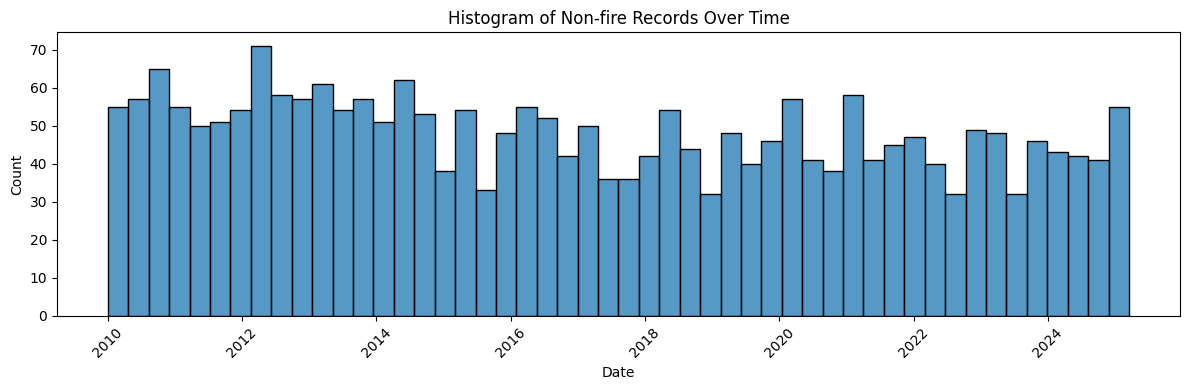

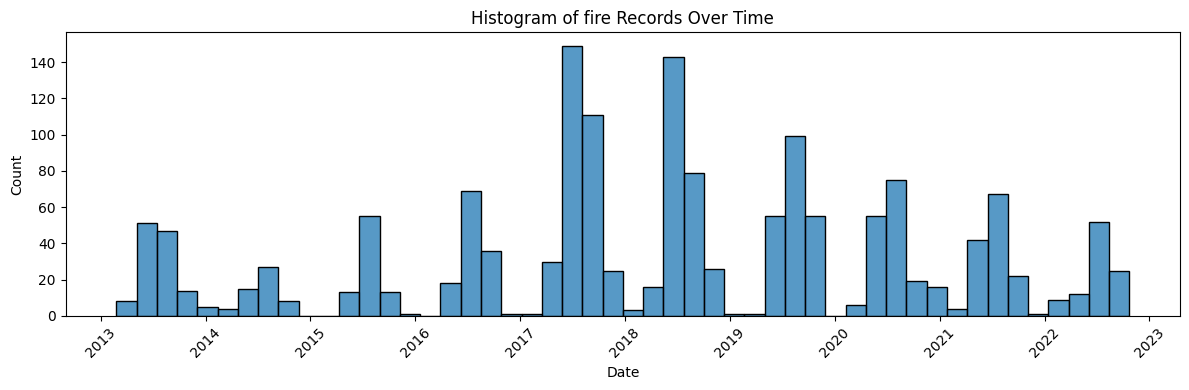

In [43]:
# Check if fire, non-fire data is distributed evenly
df_non_fire = df[df.is_fire == 0]
df_fire = df[df.is_fire == 1]

plt.figure(figsize=(12, 4))
sns.histplot(data=df_non_fire, x='date', bins=50, kde=False)
plt.title("Histogram of Non-fire Records Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
sns.histplot(data=df_fire, x='date', bins=50, kde=False)
plt.title("Histogram of fire Records Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [44]:
from collections import Counter
Counter(df.is_fire)

Counter({0: 2416, 1: 1584})

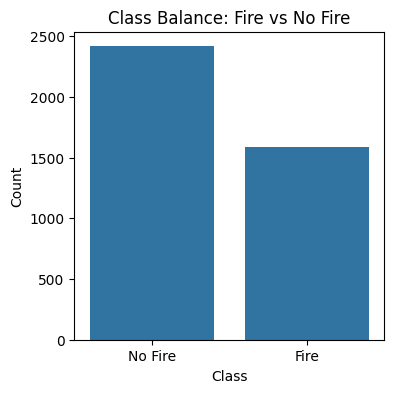

In [45]:
# Plot class balance
plt.figure(figsize=(4,4))
sns.countplot(x=df['is_fire'].map({0: 'No Fire', 1: 'Fire'}))
plt.title("Class Balance: Fire vs No Fire")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


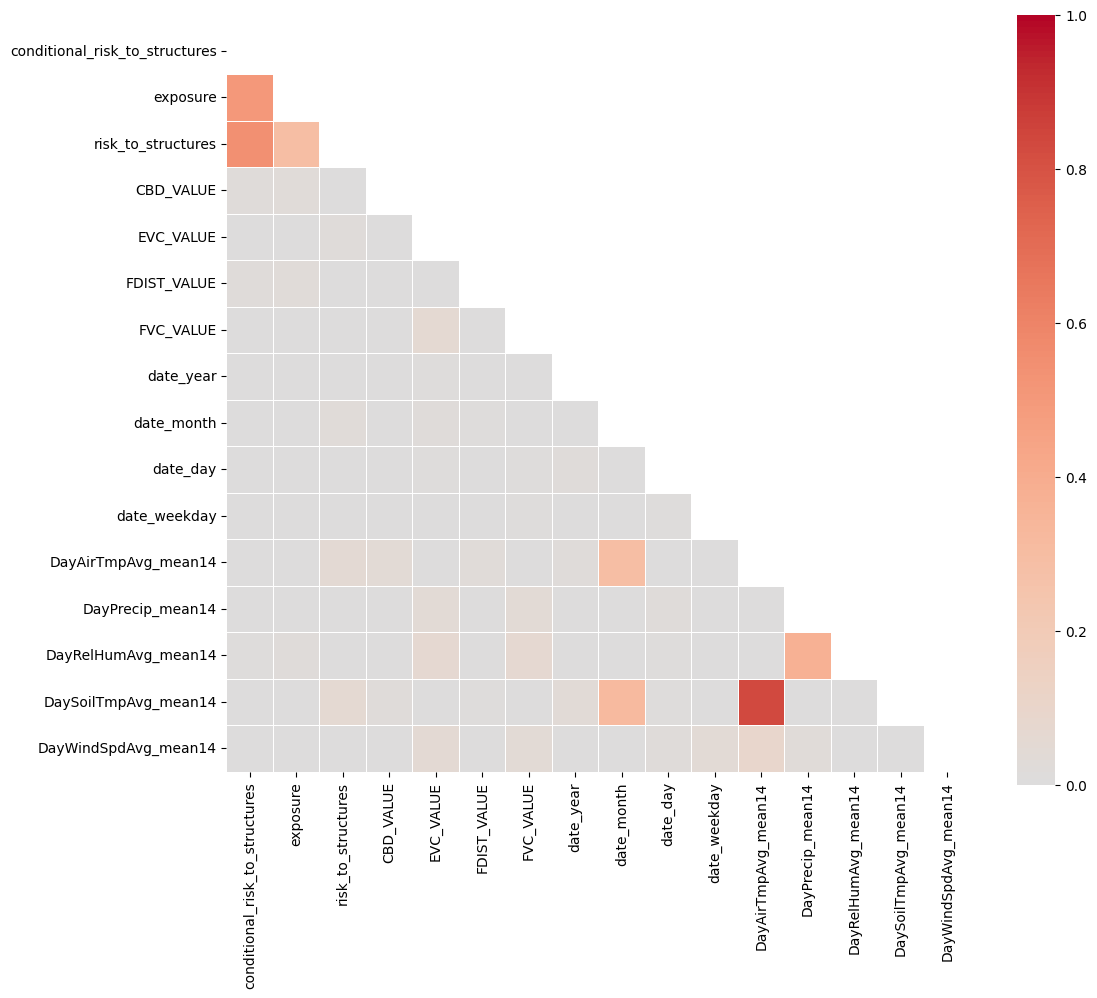

In [46]:
# Correlation heatmap for numerical features
# Just use mean climate data for correlation heatmap
df2 = df.copy()
climate_vars = ['DayAirTmpAvg', 'DayPrecip', 'DayRelHumAvg', 'DaySoilTmpAvg', 'DayWindSpdAvg']
for var in climate_vars:
    cols = [c for c in df.columns if c.startswith(var) if '_mean' not in c]
    df2.drop(columns=cols, inplace=True)
df2.drop(columns=['date'], inplace=True)

plt.figure(figsize=(12,10))
corr = df2.drop(columns=['is_fire']).corr()  # exclude the label for feature-feature correlation
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=0.5, vmin=0, vmax=1)
plt.show()


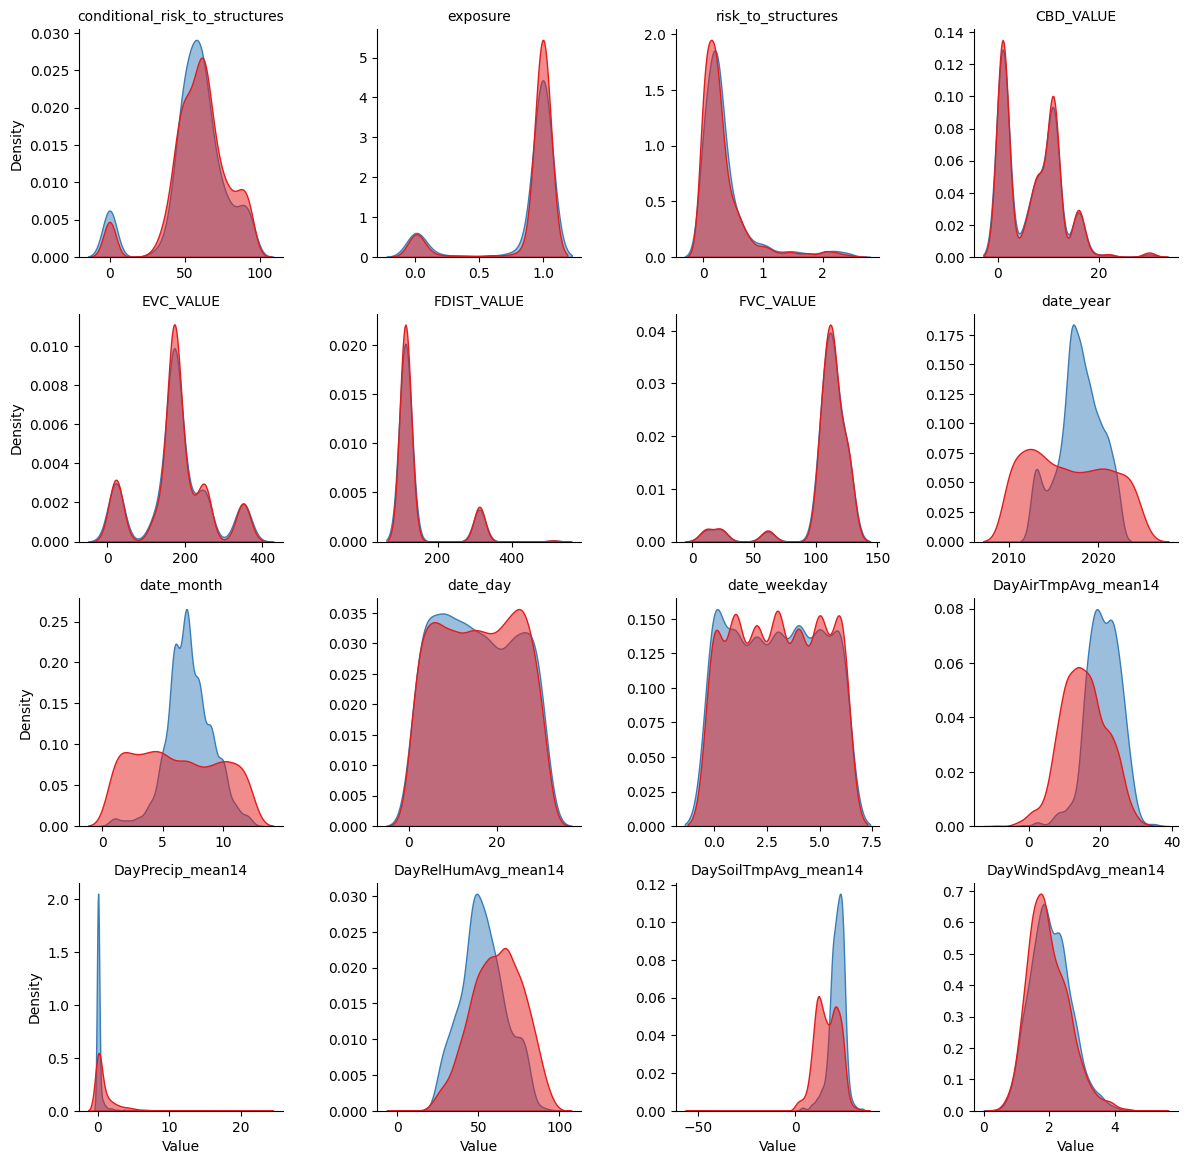

In [22]:
# Total Class-wise Feature Distribution

num_cols = df2.select_dtypes(include=['float64', 'int64']).columns.drop('is_fire')
df_melted = df2.melt(id_vars='is_fire', value_vars=num_cols, var_name='Feature', value_name='Value')

g = sns.FacetGrid(df_melted, col='Feature', col_wrap=4, sharex=False, sharey=False, height=3)
g.map_dataframe(sns.kdeplot, x='Value', hue='is_fire', common_norm=False, fill=True, alpha=0.5, palette='Set1')

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Density")
plt.subplots_adjust(top=0.95)

plt.show()

# Feature Effective

In [49]:
final_result = pd.read_csv(os.path.join(project_path, 'data','model_results', 'model_feature_set_combinations_results.csv'))
df = final_result
models = df['Model'].unique()

results = []

for model in models:
    model_df = df[df['Model'] == model]
    
    avg_f1 = model_df['F1'].max()
    avg_roc_auc = model_df['ROC_AUC'].max()
    
    baseline_df = model_df[model_df['FeatureSet'] == 'None'] if 'None' in model_df['FeatureSet'].values else model_df.iloc[[0]]
    baseline_f1 = baseline_df['F1'].values[0]
    baseline_roc_auc = baseline_df['ROC_AUC'].values[0]
    
    f1_improvement = avg_f1 - baseline_f1
    roc_auc_improvement = avg_roc_auc - baseline_roc_auc
    
    if f1_improvement > 0:
        reaction = 'Positive impact'
    elif f1_improvement < 0:
        reaction = 'Negative impact'
    else:
        reaction = 'No impact'
    
    results.append({
        'Model': model,
        'F1-score Improvement (%)': round(f1_improvement, 2),
        'ROC-AUC Improvement (%)': round(roc_auc_improvement, 2),
        'Reaction to Feature Engineering': reaction
    })

results_df = pd.DataFrame(results)
display(results_df)

,Model,F1-score Improvement (%),ROC-AUC Improvement (%),Reaction to Feature Engineering
0,XGBoost,0.02,0.02,Positive impact
1,LogisticRegression,0.00,0.00,Positive impact
2,GradientBoosting,0.03,0.03,Positive impact
3,DecisionTree,0.00,0.00,Positive impact


In [50]:
# Best model 
best_per_model = df.loc[df.groupby('Model')['F1'].idxmax()]
best_per_model = best_per_model[['Model', 'F1', 'ROC_AUC', 'Recall', 'Precision', 'Accuracy']]

display(best_per_model)

,Model,F1,ROC_AUC,Recall,Precision,Accuracy
23,DecisionTree,0.759331,0.806646,0.930599,0.641304,0.776583
694,GradientBoosting,0.790630,0.833560,0.851735,0.737705,0.829152
169,LogisticRegression,0.630934,0.699921,0.649842,0.613095,0.712067
904,XGBoost,0.798165,0.838595,0.823344,0.774481,0.842294
